Importing necessary libraries

In [1]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
!pip install tensorflow-addons==0.16.1
import tensorflow as tf
#import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00


Setting up general parameters

In [2]:
epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Loading, Preperation and Visualization

In [6]:
folder_path = "/content/drive/MyDrive/brain_tumor_dataset"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [7]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(253, 240, 240, 3) (253,)


In [19]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [8]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)
    plt.show()

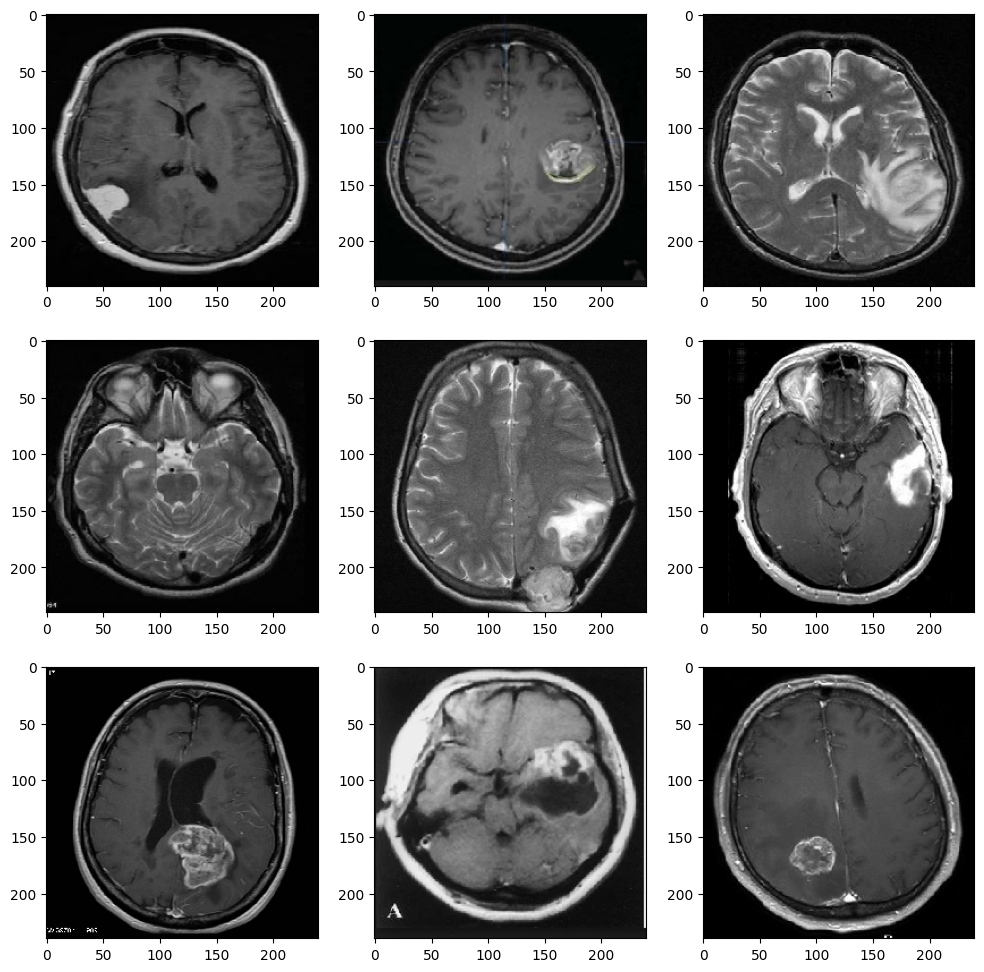

In [9]:
plot_state('yes')

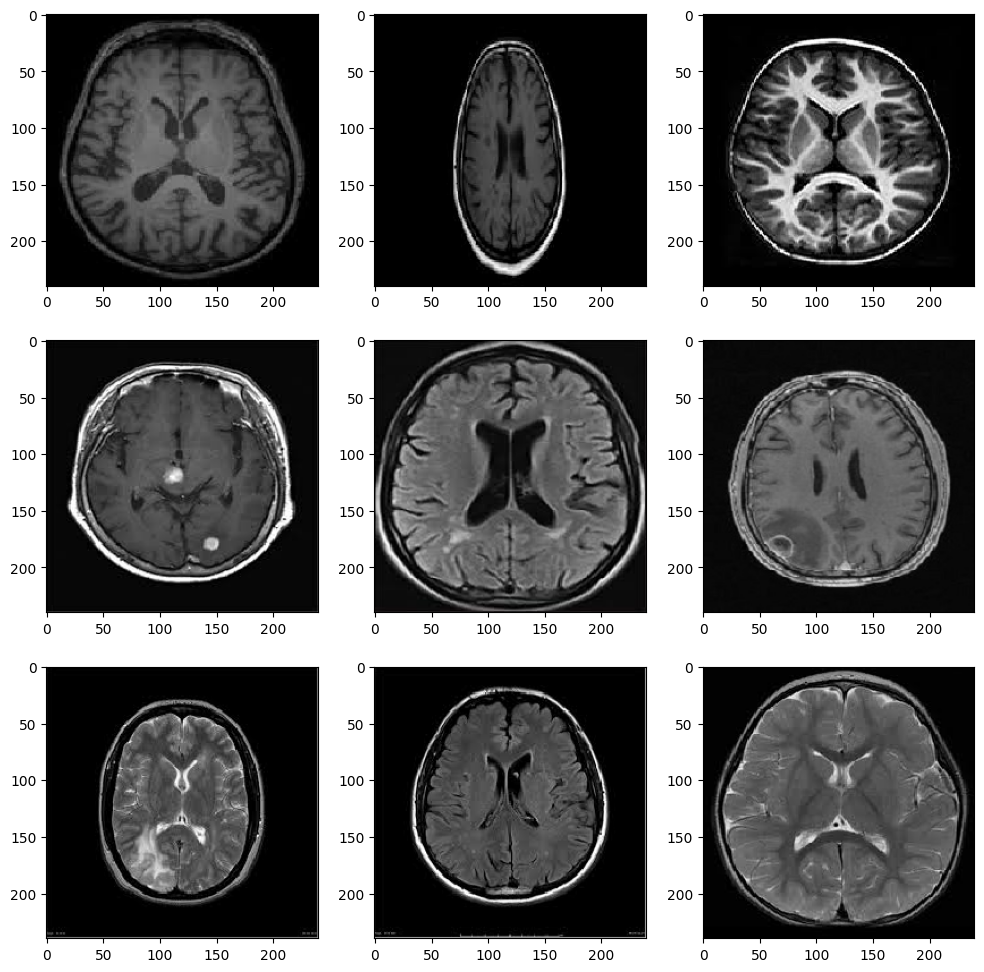

In [10]:
plot_state("no")

Modeling using CNN

In [11]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

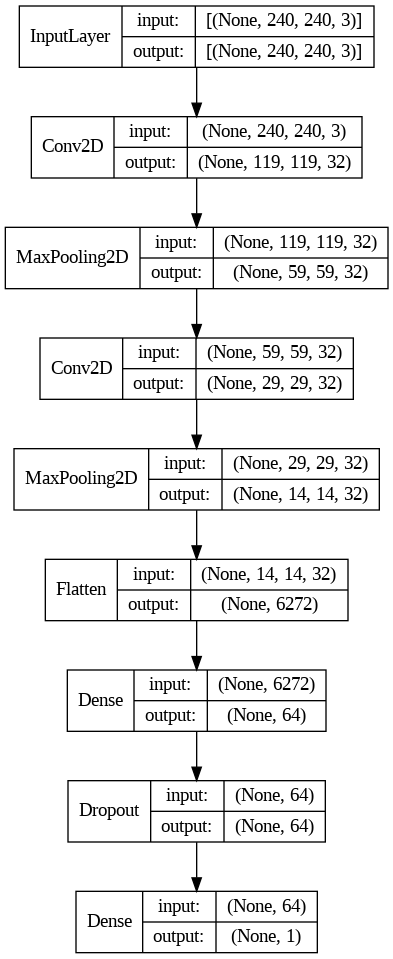

In [13]:
plot_model(model, show_shapes=True, show_layer_names=False)

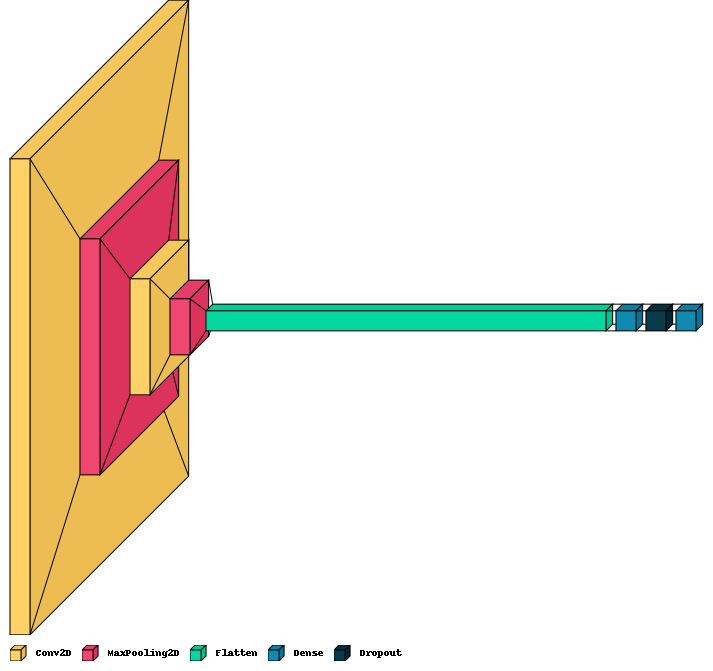

In [14]:
visualkeras.layered_view(model, legend=True)

In [20]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.294871794871795, 1: 0.8145161290322581}

In [23]:
history = model.fit(x_train,y_train,epochs = 10, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

Epoch 1/10
7/7 [==============================] - 5s 726ms/step - loss: 3.9196 - accuracy: 0.7426 - val_loss: 3.8938 - val_accuracy: 0.8039
Epoch 2/10
7/7 [==============================] - 2s 283ms/step - loss: 3.8572 - accuracy: 0.7277 - val_loss: 3.8219 - val_accuracy: 0.7843
Epoch 3/10
7/7 [==============================] - 2s 280ms/step - loss: 3.7985 - accuracy: 0.7030 - val_loss: 3.7484 - val_accuracy: 0.8039
Epoch 4/10
7/7 [==============================] - 2s 274ms/step - loss: 3.6953 - accuracy: 0.7475 - val_loss: 3.6620 - val_accuracy: 0.8039
Epoch 5/10
7/7 [==============================] - 2s 278ms/step - loss: 3.6258 - accuracy: 0.7426 - val_loss: 3.6083 - val_accuracy: 0.8039
Epoch 6/10
7/7 [==============================] - 3s 467ms/step - loss: 3.5683 - accuracy: 0.7376 - val_loss: 3.5380 - val_accuracy: 0.8039
Epoch 7/10
7/7 [==============================] - 3s 448ms/step - loss: 3.5038 - accuracy: 0.7277 - val_loss: 3.4864 - val_accuracy: 0.8039
Epoch 8/10
7/7 [====

CNN model Evaluation

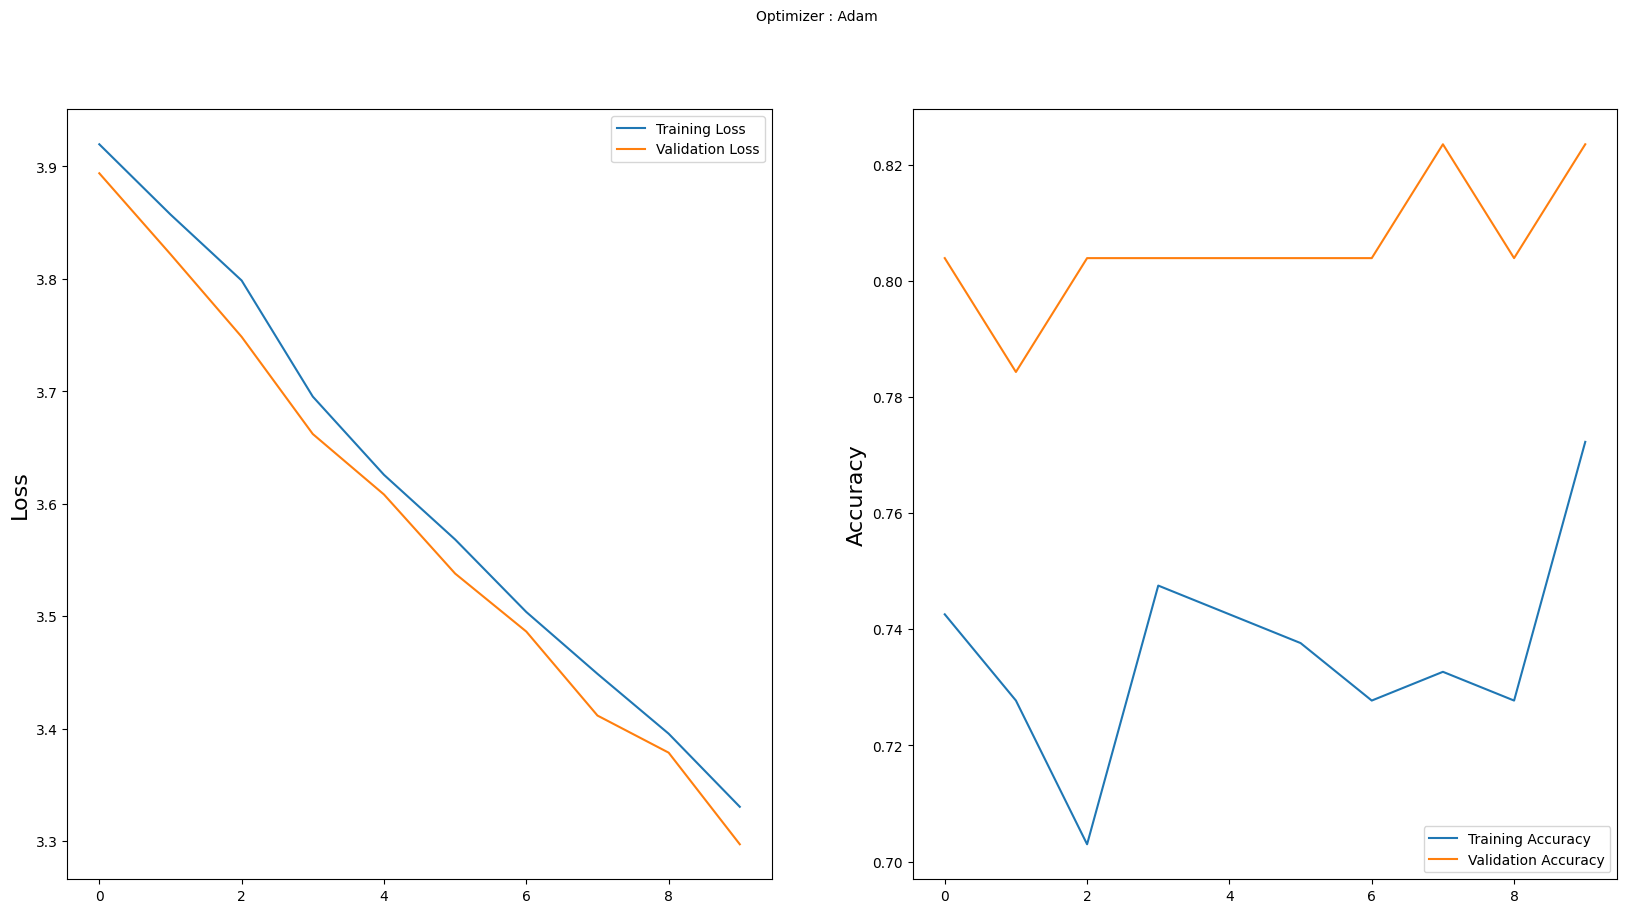

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [27]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

2/2 [==============================] - 0s 45ms/step - loss: 3.2973 - accuracy: 0.8235
The current model achieved an accuracy of 82.35%!


In [26]:
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 60ms/step


In [28]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

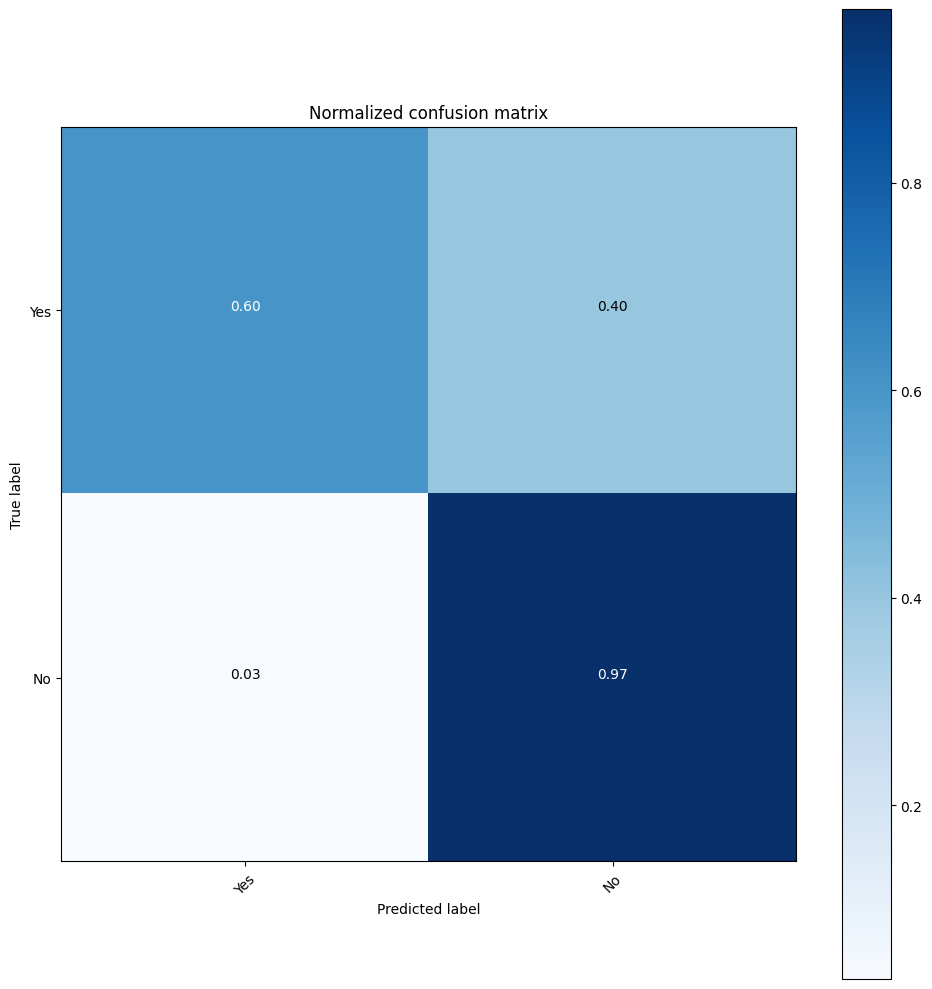

In [29]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

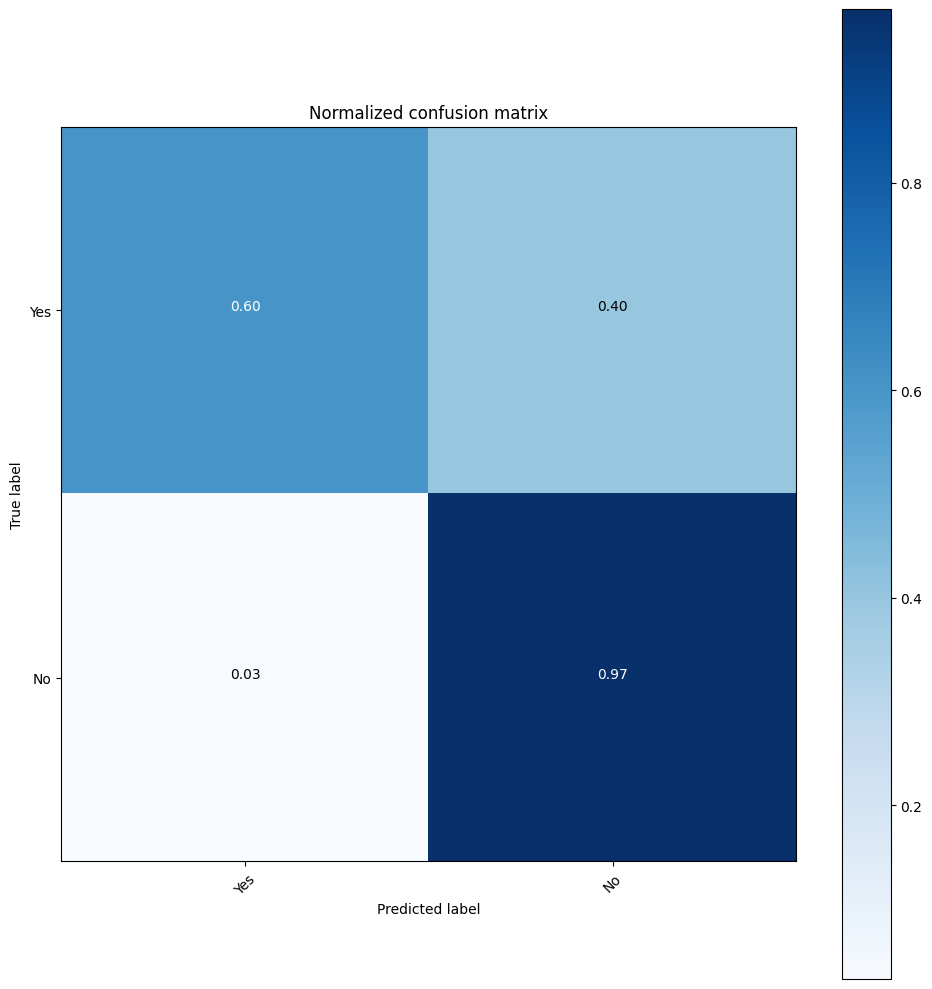

In [30]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

Modeling using Vision Transformers(ViT)

In [31]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Data augmentation

In [32]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Multi-layer perceptron

In [33]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [34]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


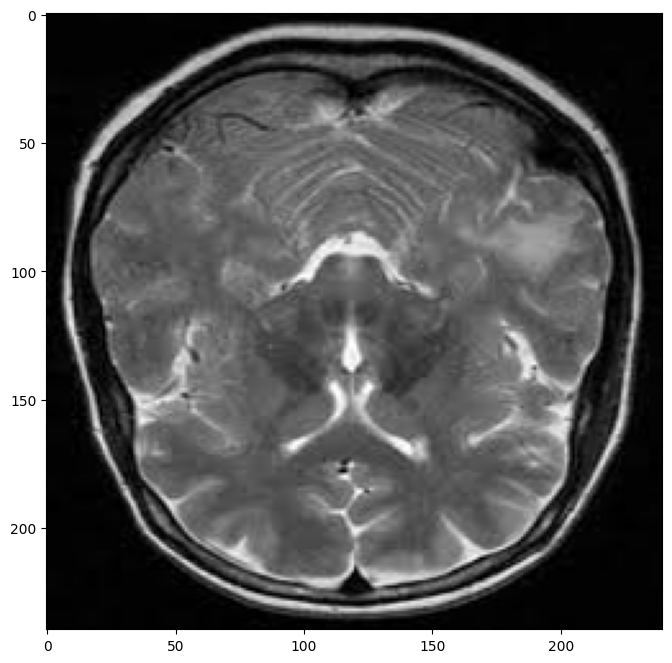

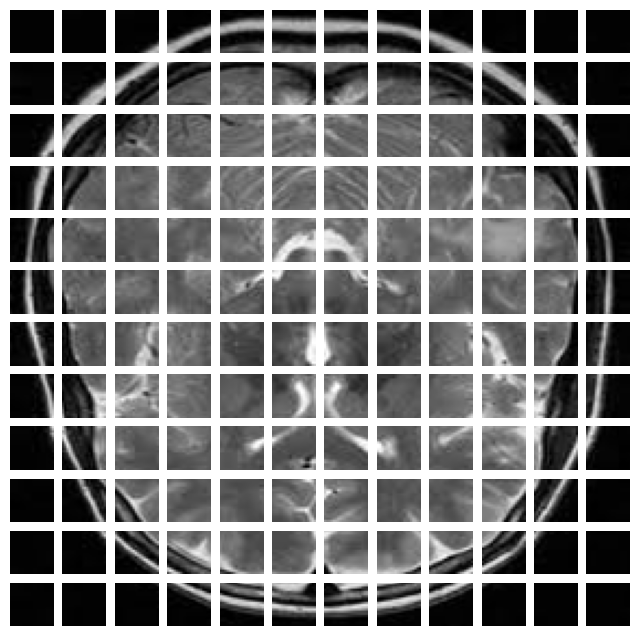

In [35]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Creating the patch encoder

In [36]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded